In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df_unidade_consumidora = pd.read_csv('./datasets/unidade_consumidora')
df_geracao = pd.read_csv('./datasets/geracao', chunksize=1000000)
df_usina = pd.read_csv('./datasets/usina')
df_cidade = pd.read_csv('./datasets/cidade')
df_endereco = pd.read_csv('./datasets/endereco')
df_estado = pd.read_csv('./datasets/estado')
df_id_ext = pd.read_csv('./datasets/id_ext')
df_usina_historico = pd.read_csv('./datasets/usina_historico')

In [4]:
# Removendo os dados ausentes da coluna potencia
df_usina.dropna(subset=['potencia'], inplace=True)

# Removendo a coluna last_plant_history_id
df_usina.drop(columns=['last_plant_history_id'], inplace=True)

In [5]:
# Selecionando 100000 dados de amostra
df_usina_amostra = df_usina.sample(n=25000, random_state=42)

# IDs usinas
ids_usinas_amostra = df_usina_amostra['id'].tolist()

In [6]:
geracao_filtrada = []

for chunk in df_geracao:
    # Filtrar dados de geracao das usinas amostra
    chunk_filtrado = chunk[chunk['id_usina'].isin(ids_usinas_amostra)]

    # Adicionar o chunk filtrado à lista
    geracao_filtrada.append(chunk_filtrado)

# Concatenar todos os chunks filtrados em um único DataFrame
df_geracao_filtrada = pd.concat(geracao_filtrada, ignore_index=True)

In [7]:
df_geracao_filtrada.dropna(subset=['quantidade', 'prognostico'], inplace=True)

In [8]:
df_cidade.rename(columns={'nome': 'nome_cidade'}, inplace=True, errors='ignore')
df_cidade.drop(columns=['created_at'], inplace=True, errors='ignore')

df_usina_historico.drop(columns=['performance_type_enum'], inplace=True, errors='ignore')
df_usina_historico.dropna(subset=['performance'], inplace=True)

df_unidade_consumidora.dropna(subset=['id_endereco'], inplace=True)

df_endereco.dropna(subset=['id_cidade'], inplace=True)

In [9]:
# Unir usina com unidade_consumidora
df = df_usina_amostra.merge(df_unidade_consumidora, left_on='unidade_consumidora_id', right_on='id', how='inner', suffixes=('', '_unidade_consumidora'))
df.drop(columns=['id_unidade_consumidora'], inplace=True)

# Unir unidade_consumidora com endereço
df = df.merge(df_endereco, left_on='id_endereco', right_on='id', how='inner', suffixes=('', '_endereco_2'))
df.drop(columns=['id_endereco_2'], inplace=True)
df['id_endereco'] = df['id_endereco'].astype(int)

# Unir endereço com cidade
df = df.merge(df_cidade, left_on='id_cidade', right_on='id', how='inner', suffixes=('', '_cidade_2'))
df.drop(columns=['id_cidade_2'], inplace=True)
df['id_cidade'] = df['id_cidade'].astype(int)

# Unir cidade com estado
df = df.merge(df_estado, left_on='id_estado', right_on='id', how='inner', suffixes=('', '_estado_2'))
df.drop(columns=['id_estado_2'], inplace=True)

# Unir usina com usina_historico para obter potência histórica
df = df.merge(df_usina_historico, left_on='id', right_on='plant_id', how='inner', suffixes=('', '_usina_historico'))
df.drop(columns=['plant_id'], inplace=True)

# Unir geracao com df
df = pd.merge(df_geracao_filtrada, df, left_on='id_usina', right_on='id', how='inner', suffixes=('', '_geracao'))
df.drop(columns=['id_geracao'], inplace=True)

df.head()

,id,data,prognostico,quantidade,id_usina,potencia,unidade_consumidora_id,id_endereco,id_cidade,nome_cidade,id_estado,denominacao,uf,regiao,id_usina_historico,power,performance,start_date
0,3198427,2020-02-20,610.17,771.00,18297,146.20,20561,15584,3,Açu,20,Rio Grande do Norte,RN,Nordeste,74876,146.20,1681.00,2020-01-29 03:00:00
1,3141723,2020-08-24,14.21,0.00,8667,3.78,9256,5720,630,Santo Antônio de Jesus,5,Bahia,BA,Nordeste,42262,3.78,1612.00,2020-04-19 03:00:00
2,3141789,2020-08-24,97.92,0.00,2314,49.58,2477,11302,1573,Águas Formosas,13,Minas Gerais,MG,Sudeste,47566,49.58,1453.00,2019-05-13 03:00:00
3,3141835,2020-08-24,34.07,22.12,14784,9.52,16243,41158,616,Salvador,5,Bahia,BA,Nordeste,66328,9.52,1495.00,2020-02-01 03:00:00
4,33658,2019-08-25,32.77,45.80,155,10.88,249,1041,4173,Portão,21,Rio Grande do Sul,RS,Sul,41796,10.88,1375.32,2019-05-20 03:00:00


In [48]:
usinas_desafio_3 = df
usinas_desafio_3["ano"] = usinas_desafio_3["data"].str[:4].astype(int)
usinas_desafio_3["ano_instalacao"] = usinas_desafio_3["start_date"].str[:4].astype(int)
usinas_desafio_3.head()

soma_quantidade = usinas_desafio_3.groupby(["id_usina", "ano"]).agg(
    quantidade=("quantidade", "sum"),
    desempenho_inicial=("performance", "first"),
    ano_instalacao=("ano_instalacao", "first")
).reset_index()

def calcular_desempenho_esperado(ano_atual, ano_instalacao, desempenho_inicial):
    anos_passados = int(ano_atual) - int(ano_instalacao)
    if anos_passados == 0:
        return desempenho_inicial
    if anos_passados == 1:
        return desempenho_inicial * 0.975
    return desempenho_inicial * (0.975 * (0.995 ** anos_passados))

soma_quantidade["desempenho_esperado"] = soma_quantidade.apply(
    lambda row: calcular_desempenho_esperado(row["ano"], row["ano_instalacao"], row["desempenho_inicial"]), axis=1
)

soma_quantidade["desvio"] = soma_quantidade["quantidade"] - soma_quantidade["desempenho_esperado"]

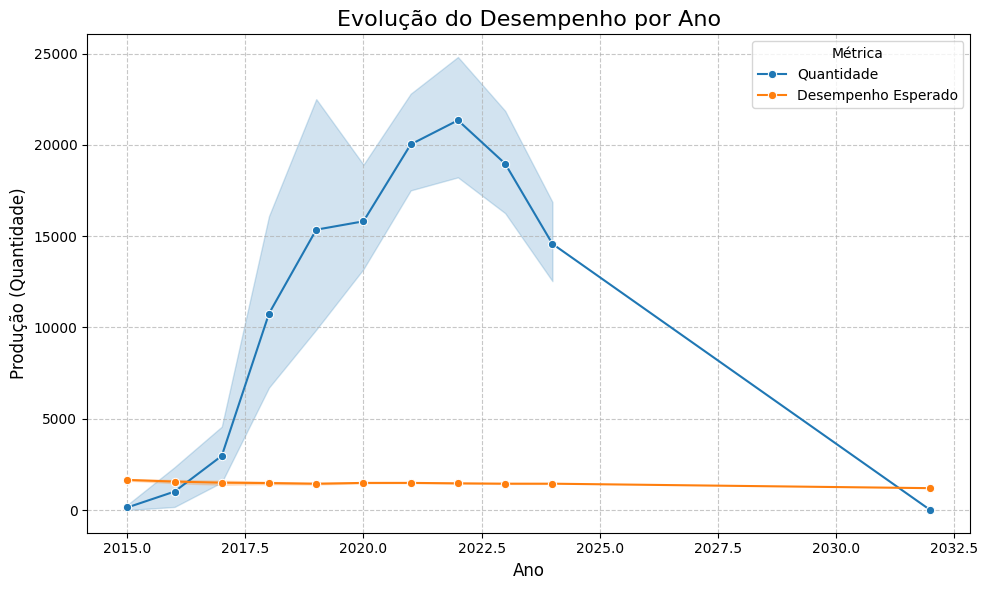

In [49]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=soma_quantidade, x="ano", y="quantidade", label="Quantidade", marker="o")
sns.lineplot(data=soma_quantidade, x="ano", y="desempenho_esperado", label="Desempenho Esperado", marker="o")
plt.title("Evolução do Desempenho por Ano", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Produção (Quantidade)", fontsize=12)
plt.legend(title="Métrica")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

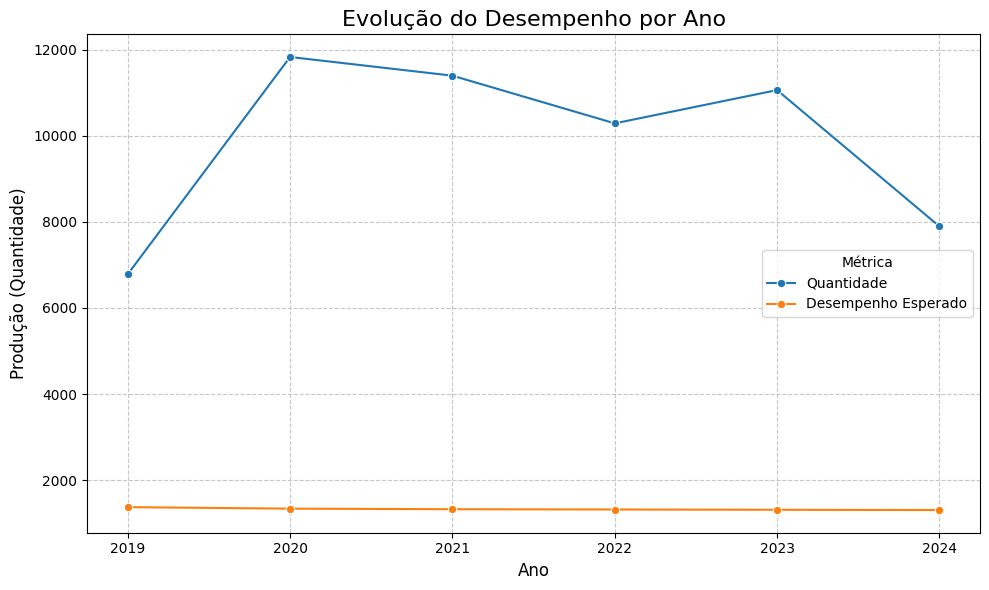

In [54]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=soma_quantidade[soma_quantidade['id_usina'] == 155], x="ano", y="quantidade", label="Quantidade", marker="o")
sns.lineplot(data=soma_quantidade[soma_quantidade['id_usina'] == 155], x="ano", y="desempenho_esperado", label="Desempenho Esperado", marker="o")
plt.title("Evolução do Desempenho por Ano", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Produção (Quantidade)", fontsize=12)
plt.legend(title="Métrica")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()